# Introduction

Dans ce notebook nous allons effectuer trois taches:
* l'analyse exploratoire (exploration et netooyage) de nos données
* traitement du texte
* extraction des features textes

# Analyse exploratoire ds données

## Import des librairies

In [1]:
%%time
import time
init_time = time.time()

import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Installation du package gensim
!pip install --no-cache-dir gensim
import gensim
from gensim.models import FastText, Word2Vec

import numpy as np
import pandas as pd
import sklearn
import pickle

from tqdm import tqdm
from collections import Counter

from matplotlib import pyplot as plt

import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords, wordnet, brown
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.feature_extraction.text import CountVectorizer


# Intallation du package contractions- https://github.com/kootenpv/contractions
!pip install contractions
import contractions


print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
print("re version:", re.__version__)
print("nltk version:", nltk.__version__)
print("gensim version:", gensim.__version__)
print("tensorflow version:", tf.__version__)
print("tensorflow_hub version:", hub.__version__)
print("tensorflow_text version:", text.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.1 MB/s eta 0:00:00
Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
pandas version: 2.2.2
numpy version: 1.26.4
skearn version: 1.6.1
re version: 2.2.1
nltk version: 3.9.1
gensim version: 4.3.3
tensorflow version: 2.18.0
tensorflow_hub version: 0.16.1
tensorflow_text version: 2.18.1
CPU times: user 7.16 s, sys: 819 ms, total: 7.98 s
Wall time: 14.5 s


## Chargement des données

In [2]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [3]:
%time
column_names = ['target', 'id', 'posted_at', 'QUERY', 'posted_by', 'content']
tweets_df = pd.read_csv(path+"/training.1600000.processed.noemoticon.csv", encoding_errors='ignore', names=column_names)
display(tweets_df.shape)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


(1600000, 6)

## Exploration

In [4]:
tweets_df.head()

,target,id,posted_at,QUERY,posted_by,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   target     1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   posted_at  1600000 non-null  object
 3   QUERY      1600000 non-null  object
 4   posted_by  1600000 non-null  object
 5   content    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
tweets_df.isna().sum()

,0
target,0
id,0
posted_at,0
QUERY,0
posted_by,0
content,0


Aucune valeur manquante n'a été detectée

In [7]:
tweets_df.QUERY.value_counts()

,count
QUERY,
NO_QUERY,1600000


Nous allons supprimer la colonne 'QUERY' car elle a une unique valeur qui n'apporte aucune variance à notre jeu de donnée.

In [8]:
tweets_df.drop(columns=['QUERY'], inplace=True)

In [9]:
tweets_df.head()

,target,id,posted_at,posted_by,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
tweets_df.target.value_counts()

,count
target,
0,800000
4,800000


TARGET a deux valeurs 0 et 4, pour plus de lisibilité nous allons remplacer par 1 ainsi npus aurons deux valeurs qui decrivent mieux la problématique etudiée (sentiment: 0-> positif et 1-> negatif)

In [11]:
tweets_df.target = tweets_df.target.replace(to_replace=4, value=1)

Les classes sont equilibrées

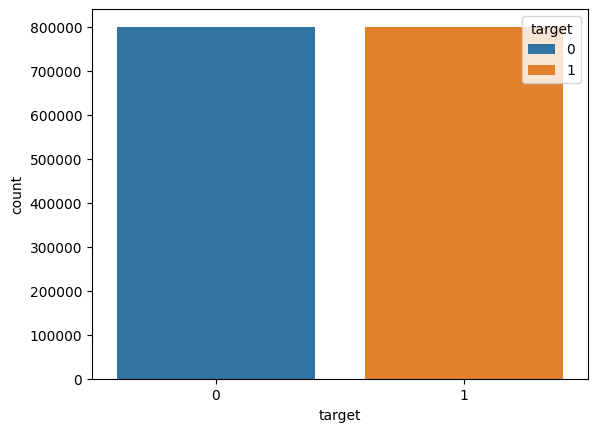

In [12]:
fig, ax = plt.subplots()
sns.countplot(data=tweets_df, x='target', ax=ax, hue='target')
xticks = ax.xaxis.get_ticks_position()
ax.xaxis.set_ticks([0, 1])
plt.show()

> Conversion explicite de la colonne **posted_at** en datetime


In [13]:
# avant
tweets_df.posted_at.dtypes

dtype('O')

In [14]:
# Suppression de 'PDT' de la chaîne
tweets_df['posted_at'] = tweets_df['posted_at'].str.replace("PDT", "", regex=False).str.strip()

# Conversion en datetime sans timezone
tweets_df['posted_at'] = pd.to_datetime(tweets_df['posted_at'], errors='coerce')

# Localisation de la timezone (US Pacific Time)
tweets_df['posted_at'] = tweets_df['posted_at'].dt.tz_localize('US/Pacific', ambiguous='NaT', nonexistent='NaT')


In [15]:
# aprés
tweets_df.posted_at.dtypes

datetime64[ns, US/Pacific]

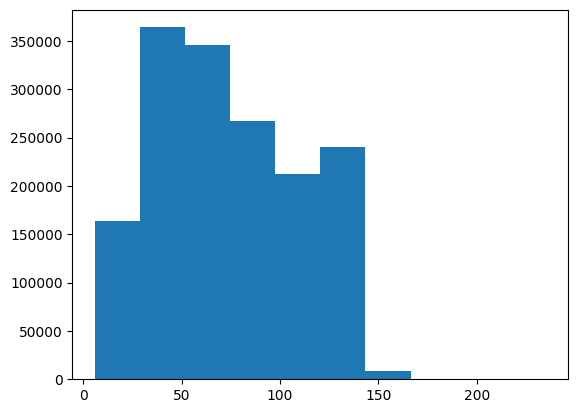

In [16]:
text_length = tweets_df['content'].str.len()
plt.hist(text_length)
plt.show()

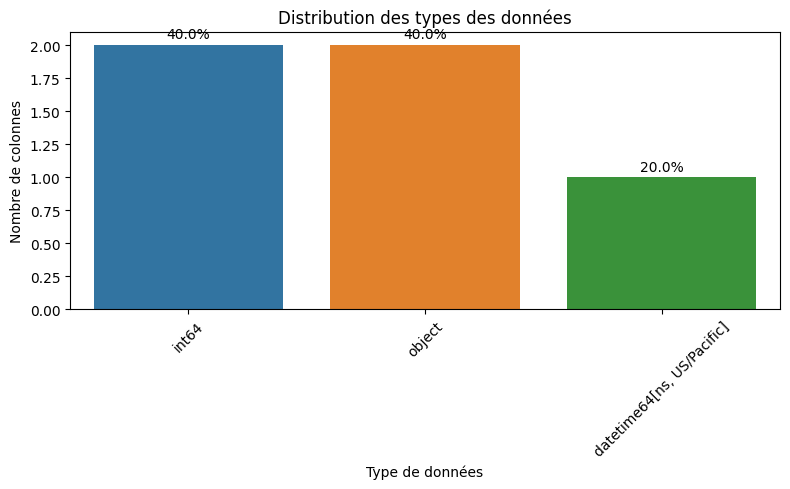

In [17]:
dtype_counts = tweets_df.dtypes.value_counts().reset_index()
dtype_counts.columns = ['dtype', 'count']

total = dtype_counts['count'].sum()
dtype_counts['percent'] = (dtype_counts['count'] / total * 100).round(1)
dtype_counts['dtype'] = dtype_counts['dtype'].astype(str)


plt.figure(figsize=(8, 5))
sns.barplot(data=dtype_counts, x='dtype', y='count', hue='dtype')

for index, row in dtype_counts.iterrows():
    plt.text(x=index, y=row['count'] + total * 0.01, s=f"{row['percent']}%", ha='center')

plt.title("Distribution des types des données")
plt.xlabel("Type de données")
plt.ylabel("Nombre de colonnes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



> Tweets dupliqués



In [18]:
tweets_df[tweets_df.duplicated(subset=['id', 'content'])]

,target,id,posted_at,posted_by,content
800261,1,1467863684,2009-04-06 22:33:35-07:00,DjGundam,Awwh babs... you look so sad underneith that s...
800300,1,1467880442,2009-04-06 22:38:04-07:00,iCalvin,Haven't tweeted nearly all day Posted my webs...
801280,1,1468053611,2009-04-06 23:28:09-07:00,mariejamora,@hellobebe I also send some updates in plurk b...
801573,1,1468100580,2009-04-06 23:42:57-07:00,cristygarza,good night swetdreamss to everyonee and jare...
801650,1,1468115720,2009-04-06 23:48:00-07:00,WarholGirl,@ientje89 aw i'm fine too thanks! yeah i miss ...
...,...,...,...,...,...
1598780,1,2193278017,2009-06-16 08:14:22-07:00,janiecwales,oh dear HH is back please twitter do somethi...
1599298,1,2193403830,2009-06-16 08:24:44-07:00,lauren__x33,english exam went okay revising for fre...
1599385,1,2193428118,2009-06-16 08:26:44-07:00,bubbles00,"finally finished typing!!!! Woohoooo , still ..."
1599440,1,2193451289,2009-06-16 08:28:37-07:00,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."


In [19]:
tweets_df.loc[tweets_df.id==2193576442]

,target,id,posted_at,posted_by,content
524688,0,2193576442,2009-06-16 08:38:45-07:00,emma_b_xox,Had an injection today. Not fun the rrst of t...
1599931,1,2193576442,2009-06-16 08:38:45-07:00,emma_b_xox,Had an injection today. Not fun the rrst of t...


L’exemple ci-dessous illustre un cas de duplication : deux observations partagent le même identifiant (`id`) et le même contenu (`content`). Cependant, elles sont associées à des **labels différents** (`0` pour l’une et `1` pour l’autre), ce qui crée une incohérence.

Pour gérer ce type de cas, nous adoptons la stratégie suivante :

- **Si les observations dupliquées ont des labels différents** :  
  *Nous supprimons les deux*, car cette contradiction rend le label peu fiable et pourrait introduire du bruit dans l’apprentissage du modèle.

- **Si les observations dupliquées ont le même label** :  
  *Nous ne conservons qu’une seule occurrence*, afin de réduire les redondances et éviter de biaiser le modèle avec des doublons.

> Cette stratégie permet de nettoyer les données de manière prudente, en écartant les cas ambigus et en limitant la surreprésentation de certains exemples.



In [20]:
# les doublons ayant les memes labels
print(tweets_df[tweets_df.duplicated(subset=['id', 'content', 'target'])])

Empty DataFrame
Columns: [target, id, posted_at, posted_by, content]
Index: []


In [21]:
# les doublons ayant differents labels
duplicate_rows = tweets_df.duplicated(subset=['id', 'content'], keep=False)
display(tweets_df[duplicate_rows].info())

<class 'pandas.core.frame.DataFrame'>
Index: 3370 entries, 213 to 1599931
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype                     
---  ------     --------------  -----                     
 0   target     3370 non-null   int64                     
 1   id         3370 non-null   int64                     
 2   posted_at  3370 non-null   datetime64[ns, US/Pacific]
 3   posted_by  3370 non-null   object                    
 4   content    3370 non-null   object                    
dtypes: datetime64[ns, US/Pacific](1), int64(2), object(2)
memory usage: 158.0+ KB


None

In [22]:
# Suppression des doublons
tweets_df = tweets_df[~(duplicate_rows)]

In [23]:
tweets_df.shape

(1596630, 5)



> suppression des doublons (user, message)



In [24]:
rows = tweets_df.duplicated(subset=['content', 'posted_by'], keep=False)
rows.sum()

5431

In [25]:
duplicated_contents = tweets_df[rows]

In [26]:
duplicated_contents

,target,id,posted_at,posted_by,content
238,0,1467872759,2009-04-06 22:35:59-07:00,Augustina22CA,"im lonely keep me company! 22 female, california"
599,0,1467963477,2009-04-06 23:01:15-07:00,Augustina22,"im lonely keep me company! 22 female, new york"
2149,0,1468316454,2009-04-07 00:56:00-07:00,Augustina22CA,"im lonely keep me company! 22 female, california"
3469,0,1468602199,2009-04-07 02:40:02-07:00,ammaryasir,"cant eat, drink or breath properly thanks to t..."
3732,0,1468662767,2009-04-07 03:01:40-07:00,FranciscoAndre,I'm not liking that new iTunes Pricing at all....
...,...,...,...,...,...
1598959,1,2193318357,2009-06-16 08:17:40-07:00,ummsistweets,cedar point with my biffs
1599353,1,2193427113,2009-06-16 08:26:38-07:00,parawhore182,Im busy. Drooling. Over this video. ;) but ye...
1599354,1,2193427134,2009-06-16 08:26:38-07:00,parawhore182,Im busy. Drooling. Over this video. ;) but ye...
1599377,1,2193427910,2009-06-16 08:26:43-07:00,ummsistweets,cedar point with my biffs


In [27]:
tweets_df[tweets_df['posted_by'].str.strip() == 'ummsistweets']

,target,id,posted_at,posted_by,content
1298633,1,2005308803,2009-06-02 09:30:41-07:00,ummsistweets,sew excited
1598959,1,2193318357,2009-06-16 08:17:40-07:00,ummsistweets,cedar point with my biffs
1599377,1,2193427910,2009-06-16 08:26:43-07:00,ummsistweets,cedar point with my biffs


In [28]:
# les doublons ayant les memes labels
duplicate_rows = tweets_df.duplicated(subset=['content', 'posted_by', 'target'])
display(tweets_df[duplicate_rows].info())

<class 'pandas.core.frame.DataFrame'>
Index: 3541 entries, 2149 to 1599531
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype                     
---  ------     --------------  -----                     
 0   target     3541 non-null   int64                     
 1   id         3541 non-null   int64                     
 2   posted_at  3541 non-null   datetime64[ns, US/Pacific]
 3   posted_by  3541 non-null   object                    
 4   content    3541 non-null   object                    
dtypes: datetime64[ns, US/Pacific](1), int64(2), object(2)
memory usage: 166.0+ KB


None

In [29]:
# Suppression des doublons
tweets_df = tweets_df.drop_duplicates(subset=['content', 'posted_by'], keep='first')
tweets_df.shape

(1593071, 5)

In [30]:
tweets_df[tweets_df['posted_by'].str.strip() == 'ummsistweets']

,target,id,posted_at,posted_by,content
1298633,1,2005308803,2009-06-02 09:30:41-07:00,ummsistweets,sew excited
1598959,1,2193318357,2009-06-16 08:17:40-07:00,ummsistweets,cedar point with my biffs


In [31]:
# les doublons ayant differents labels
print(tweets_df[tweets_df.duplicated(subset=['id', 'content'])])

Empty DataFrame
Columns: [target, id, posted_at, posted_by, content]
Index: []


# Nettoyage du contenu

L’approche la plus courante dans le nettoyage de texte consiste à uniformiser la casse (mettre en majuscules ou en minuscules), en raison de la diversité des capitalisations dans la formation des phrases. Cette technique permet de projeter tous les mots du texte et du document dans le même espace de caractéristiques. Toutefois, elle peut poser problème dans des cas exceptionnels comme "USA" ou "UK", ce qui peut être résolu en utilisant des techniques de correction des fautes de frappe, de traitement du langage familier, des acronymes ou des abréviations informelles.[link text](https://)

## Mise en minuscule

In [32]:
tweets_df["content_clean"] = tweets_df["content"].apply(lambda x: x.lower())
display(tweets_df.head())

,target,id,posted_at,posted_by,content,content_clean
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many times for the ball. man...
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."


## Étendre les contractions

Nous utilisons le package [contractions](https://github.com/kootenpv/contractions) pour développer les contractions en anglais, par exemple `we'll` devient `we will`, ou `we shouldn't've` devient `we should not have`.

In [33]:
%%time
# Test
test_text = """
            Y'all can't expand contractions I'd think. I'd like to know how I'd done that!
            We're going to the zoo and I don't think I'll be home for dinner.
            Theyre going to the zoo and she'll be home for dinner.
            We should've do it in here but we shouldn't've eat it
            """
print("Test: ", contractions.fix(test_text))

Test:  
            You all cannot expand contractions I would think. I would like to know how I would done that!
            We are going to the zoo and I do not think I will be home for dinner.
            They Are going to the zoo and she will be home for dinner.
            We should have do it in here but we should not have eat it
            
CPU times: user 328 µs, sys: 0 ns, total: 328 µs
Wall time: 334 µs


In [34]:
%%time
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: contractions.fix(x))

# double check
print(tweets_df["content"][12])
print(tweets_df["content_clean"][12])

@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
@caregiving i could not bear to watch it.  and i thought the ua loss was embarrassing . . . . .
CPU times: user 10.4 s, sys: 106 ms, total: 10.5 s
Wall time: 10.5 s


## Suppression du bruit (Noise Removal)

Les données textuelles peuvent contenir divers caractères inutiles ou de la ponctuation, tels que des URLs, des balises HTML, des caractères non-ASCII, ou d'autres caractères spéciaux (symboles, emojis, et autres caractères graphiques).

### Suppression des caractéres numerique

In [35]:
def remove_numerical_chars(text):
    """
        supprime les caractéres numerique du texte
    """
    return re.sub(r'\d+', '', text).strip()

In [36]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_numerical_chars(x))

### Suppression des URLs

In [37]:
def remove_URL(text):
    """
        Supprime des URLs du texte
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [38]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_URL(x))

print(tweets_df["content"][37])
print(tweets_df["content_clean"][37])

@MissXu sorry! bed time came here (GMT+1)   http://is.gd/fNge
@missxu sorry! bed time came here (gmt+)   


### Suppression des tags HTML

In [39]:
def remove_html(text):
    """
        Supprime les tags HTML du texte
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

In [40]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_html(x))

### Remove Non-ASCI

In [41]:
def remove_non_ascii(text):
    """
        supprime les caractères non ASCII du texte
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable])

In [42]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_non_ascii(x))

## Suppression des ponctuations

In [43]:
def remove_punct(text):
    """
        supprime les ponctuations du texte
    """
    return text.translate(str.maketrans('', '', string.punctuation))

In [44]:
tweets_df["content_clean"] = tweets_df["content_clean"].apply(lambda x: remove_punct(x))

print(tweets_df["content"][5])
print(tweets_df["content_clean"][5])
print("---"*10)
print(tweets_df["content"][7597])
print(tweets_df["content_clean"][7597])

@Kwesidei not the whole crew 
kwesidei not the whole crew
------------------------------
I just got my first fail whale...  @Twitter.
i just got my first fail whale  twitter


# Prétraitement du texte

## Tokenization


In [45]:
%%time
nltk.download("punkt_tab")
tweets_df['tokenized'] = tweets_df['content_clean'].apply(word_tokenize)
tweets_df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


CPU times: user 2min 5s, sys: 1.42 s, total: 2min 6s
Wall time: 2min 6s


,target,id,posted_at,posted_by,content,content_clean,tokenized
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that is a bummer you should...,"[switchfoot, awww, that, is, a, bummer, you, s..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f..."
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...,"[kenichan, i, dived, many, times, for, the, ba..."
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it is not behaving at all i...,"[nationwideclass, no, it, is, not, behaving, a..."


## Suppression des mots vides (et/ou des mots fréquents / rares)

Les mots vides (*stop words*) sont des mots courants dans une langue qui apparaissent très fréquemment, mais n’apportent que peu ou pas d’information utile à la phrase. Par exemple, des mots comme {“a”, “about”, “above”, “across”, “after”, “afterward”, “again”, ...} peuvent être considérés comme des mots vides. Traditionnellement, on choisit de les supprimer lors de la phase de prétraitement du texte.

In [46]:
%%time
nltk.download("stopwords")

stop = set(stopwords.words('english'))
tweets_df['stopwords_removed'] = tweets_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
tweets_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


CPU times: user 7.68 s, sys: 140 ms, total: 7.82 s
Wall time: 7.94 s


,target,id,posted_at,posted_by,content,content_clean,tokenized,stopwords_removed
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that is a bummer you should...,"[switchfoot, awww, that, is, a, bummer, you, s...","[switchfoot, awww, bummer, shoulda, got, david..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...,"[kenichan, i, dived, many, times, for, the, ba...","[kenichan, dived, many, times, ball, managed, ..."
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it is not behaving at all i...,"[nationwideclass, no, it, is, not, behaving, a...","[nationwideclass, behaving, mad, see]"


## Étiquetage (POS Tagging)

L’étiquetage (*Part of Speech Tagging*, ou POS tagging) consiste à identifier la nature grammaticale de chaque mot dans un texte (nom, verbe, adjectif, etc.).

In [47]:
%%time
nltk.download('wordnet')
nltk.download('brown')
wordnet_map = {"N":wordnet.NOUN,
               "V":wordnet.VERB,
               "J":wordnet.ADJ,
               "R":wordnet.ADV
              }

train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)

    # map the pos tagging output with wordnet output
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


CPU times: user 3.7 s, sys: 188 ms, total: 3.89 s
Wall time: 4.9 s


In [48]:
pos_tag_wordnet(tweets_df['stopwords_removed'][2])

[('kenichan', 'n'),
 ('dived', 'n'),
 ('many', 'n'),
 ('times', 'n'),
 ('ball', 'n'),
 ('managed', 'v'),
 ('save', 'v'),
 ('rest', 'n'),
 ('go', 'v'),
 ('bounds', 'n')]

In [49]:
%%time
tweets_df['combined_postag_wnet'] = tweets_df['stopwords_removed'].apply(lambda x: pos_tag_wordnet(x))
tweets_df.head()

CPU times: user 23.8 s, sys: 696 ms, total: 24.5 s
Wall time: 24.4 s


,target,id,posted_at,posted_by,content,content_clean,tokenized,stopwords_removed,combined_postag_wnet
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that is a bummer you should...,"[switchfoot, awww, that, is, a, bummer, you, s...","[switchfoot, awww, bummer, shoulda, got, david...","[(switchfoot, n), (awww, n), (bummer, n), (sho..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,...","[(upset, n), (update, n), (facebook, n), (text..."
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...,"[kenichan, i, dived, many, times, for, the, ba...","[kenichan, dived, many, times, ball, managed, ...","[(kenichan, n), (dived, n), (many, n), (times,..."
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[(whole, a), (body, n), (feels, v), (itchy, n)..."
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it is not behaving at all i...,"[nationwideclass, no, it, is, not, behaving, a...","[nationwideclass, behaving, mad, see]","[(nationwideclass, n), (behaving, v), (mad, a)..."


## Lemmatization

In [50]:
def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

### Lemmatization sans POS Tagging:

In [51]:
%%time
lemmatizer = WordNetLemmatizer()

tweets_df['lemmatize_word_wo_pos'] = tweets_df['stopwords_removed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
tweets_df.head()

CPU times: user 50 s, sys: 364 ms, total: 50.4 s
Wall time: 50.3 s


,target,id,posted_at,posted_by,content,content_clean,tokenized,stopwords_removed,combined_postag_wnet,lemmatize_word_wo_pos
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that is a bummer you should...,"[switchfoot, awww, that, is, a, bummer, you, s...","[switchfoot, awww, bummer, shoulda, got, david...","[(switchfoot, n), (awww, n), (bummer, n), (sho...","[switchfoot, awww, bummer, shoulda, got, david..."
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,...","[(upset, n), (update, n), (facebook, n), (text...","[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...,"[kenichan, i, dived, many, times, for, the, ba...","[kenichan, dived, many, times, ball, managed, ...","[(kenichan, n), (dived, n), (many, n), (times,...","[kenichan, dived, many, time, ball, managed, s..."
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[(whole, a), (body, n), (feels, v), (itchy, n)...","[whole, body, feel, itchy, like, fire]"
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it is not behaving at all i...,"[nationwideclass, no, it, is, not, behaving, a...","[nationwideclass, behaving, mad, see]","[(nationwideclass, n), (behaving, v), (mad, a)...","[nationwideclass, behaving, mad, see]"


In [52]:
print(tweets_df["combined_postag_wnet"][29])
print(tweets_df["lemmatize_word_wo_pos"][29])

[('meh', 'n'), ('almost', 'r'), ('lover', 'n'), ('exception', 'n'), ('track', 'n'), ('gets', 'v'), ('depressed', 'n'), ('every', 'n'), ('time', 'n')]
['meh', 'almost', 'lover', 'exception', 'track', 'get', 'depressed', 'every', 'time']


### Lemmatization avec POS Tagging:

In [53]:
%%time
lemmatizer = WordNetLemmatizer()

tweets_df['lemmatize_word_w_pos'] = tweets_df['combined_postag_wnet'].apply(lambda x: lemmatize_word(x))
tweets_df['lemmatize_text'] = [' '.join(map(str, l)) for l in tweets_df['lemmatize_word_w_pos']]
tweets_df.head()

CPU times: user 53.7 s, sys: 497 ms, total: 54.2 s
Wall time: 54.1 s


,target,id,posted_at,posted_by,content,content_clean,tokenized,stopwords_removed,combined_postag_wnet,lemmatize_word_wo_pos,lemmatize_word_w_pos,lemmatize_text
0,0,1467810369,2009-04-06 22:19:45-07:00,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that is a bummer you should...,"[switchfoot, awww, that, is, a, bummer, you, s...","[switchfoot, awww, bummer, shoulda, got, david...","[(switchfoot, n), (awww, n), (bummer, n), (sho...","[switchfoot, awww, bummer, shoulda, got, david...","[switchfoot, awww, bummer, shoulda, get, david...",switchfoot awww bummer shoulda get david carr ...
1,0,1467810672,2009-04-06 22:19:49-07:00,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,...","[(upset, n), (update, n), (facebook, n), (text...","[upset, update, facebook, texting, might, cry,...","[upset, update, facebook, texting, might, cry,...",upset update facebook texting might cry result...
2,0,1467810917,2009-04-06 22:19:53-07:00,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...,"[kenichan, i, dived, many, times, for, the, ba...","[kenichan, dived, many, times, ball, managed, ...","[(kenichan, n), (dived, n), (many, n), (times,...","[kenichan, dived, many, time, ball, managed, s...","[kenichan, dived, many, time, ball, manage, sa...",kenichan dived many time ball manage save rest...
3,0,1467811184,2009-04-06 22:19:57-07:00,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[(whole, a), (body, n), (feels, v), (itchy, n)...","[whole, body, feel, itchy, like, fire]","[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire
4,0,1467811193,2009-04-06 22:19:57-07:00,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it is not behaving at all i...,"[nationwideclass, no, it, is, not, behaving, a...","[nationwideclass, behaving, mad, see]","[(nationwideclass, n), (behaving, v), (mad, a)...","[nationwideclass, behaving, mad, see]","[nationwideclass, behave, mad, see]",nationwideclass behave mad see


In [54]:
print(tweets_df["content"][8])
print(tweets_df["combined_postag_wnet"][8])
print(tweets_df["lemmatize_word_wo_pos"][8])
print(tweets_df["lemmatize_word_w_pos"][8])

@Tatiana_K nope they didn't have it 
[('tatianak', 'n'), ('nope', 'n')]
['tatianak', 'nope']
['tatianak', 'nope']


Comparison between original text and the lammatized text:

In [55]:
display(tweets_df["content"][0], tweets_df["lemmatize_text"][0])

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

'switchfoot awww bummer shoulda get david carr third day'



> Most frequent words



In [56]:
tokens = tweets_df["lemmatize_text"].str.split()
all_words = [word for sublist in tokens for word in sublist]

word_counts = Counter(all_words)

top_n = 20
most_common_words = word_counts.most_common(top_n)

words, counts = zip(*most_common_words)

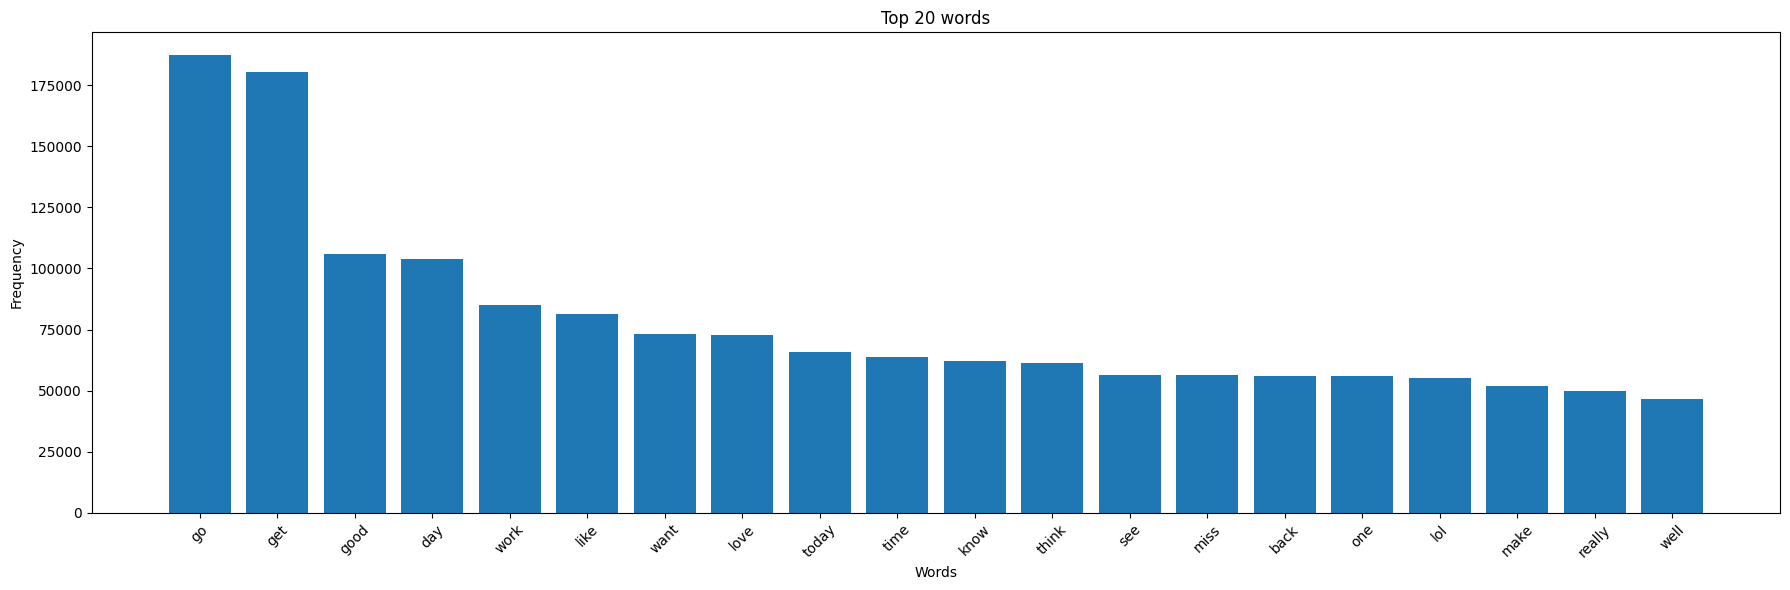

In [57]:
plt.figure(figsize=(18, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title(f"Top {top_n} words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Extraction des Features texte



## BOW - CountVectorizer

In [58]:
def cv(data, ngram = 1, MAX_NB_WORDS = 5000):
    count_vectorizer = CountVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = count_vectorizer.fit_transform(data)
    print("count vectorize with", emb.shape[1], "features")
    return emb, count_vectorizer

In [59]:
def print_out(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    print(feat.get_feature_names_out(), "\n")
    print(ngram,"bag-of-feature: ")
    print(test_cv_1gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names_out()).head(), "\n")
    print(ngram,"vector example:")
    print(tweets_df["lemmatize_text"][compared_sentence])
    print(emb[compared_sentence], "\n")

In [60]:
test_corpus = tweets_df["lemmatize_text"][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_cv_em_1gram, test_cv_1gram = cv(test_corpus, ngram=1)
print_out(test_cv_em_1gram, test_cv_1gram, ngram="Uni-gram")

The test corpus:  ['switchfoot awww bummer shoulda get david carr third day', 'upset update facebook texting might cry result school today also blah', 'kenichan dived many time ball manage save rest go bound', 'whole body feel itchy like fire', 'nationwideclass behave mad see'] 

count vectorize with 40 features
Uni-gram bag-of-words: 
['also' 'awww' 'ball' 'behave' 'blah' 'body' 'bound' 'bummer' 'carr' 'cry'
 'david' 'day' 'dived' 'facebook' 'feel' 'fire' 'get' 'go' 'itchy'
 'kenichan' 'like' 'mad' 'manage' 'many' 'might' 'nationwideclass' 'rest'
 'result' 'save' 'school' 'see' 'shoulda' 'switchfoot' 'texting' 'third'
 'time' 'today' 'update' 'upset' 'whole'] 

Uni-gram bag-of-feature: 
{'switchfoot': 32, 'awww': 1, 'bummer': 7, 'shoulda': 31, 'get': 16, 'david': 10, 'carr': 8, 'third': 34, 'day': 11, 'upset': 38, 'update': 37, 'facebook': 13, 'texting': 33, 'might': 24, 'cry': 9, 'result': 27, 'school': 29, 'today': 36, 'also': 0, 'blah': 4, 'kenichan': 19, 'dived': 12, 'many': 23, '

In [61]:
test_cv_em_2gram, test_cv_2gram = cv(test_corpus, ngram=2)
print_out(test_cv_em_2gram, test_cv_2gram, ngram="Bi-gram")

count vectorize with 35 features
Bi-gram bag-of-words: 
['also blah' 'awww bummer' 'ball manage' 'behave mad' 'body feel'
 'bummer shoulda' 'carr third' 'cry result' 'david carr' 'dived many'
 'facebook texting' 'feel itchy' 'get david' 'go bound' 'itchy like'
 'kenichan dived' 'like fire' 'mad see' 'manage save' 'many time'
 'might cry' 'nationwideclass behave' 'rest go' 'result school'
 'save rest' 'school today' 'shoulda get' 'switchfoot awww'
 'texting might' 'third day' 'time ball' 'today also' 'update facebook'
 'upset update' 'whole body'] 

Bi-gram bag-of-feature: 
{'switchfoot': 32, 'awww': 1, 'bummer': 7, 'shoulda': 31, 'get': 16, 'david': 10, 'carr': 8, 'third': 34, 'day': 11, 'upset': 38, 'update': 37, 'facebook': 13, 'texting': 33, 'might': 24, 'cry': 9, 'result': 27, 'school': 29, 'today': 36, 'also': 0, 'blah': 4, 'kenichan': 19, 'dived': 12, 'many': 23, 'time': 35, 'ball': 2, 'manage': 22, 'save': 28, 'rest': 26, 'go': 17, 'bound': 6, 'whole': 39, 'body': 5, 'feel': 14,

In [62]:
test_cv_em_3gram, test_cv_3gram = cv(test_corpus, ngram=3)
print_out(test_cv_em_2gram, test_cv_2gram, ngram="Tri-gram")

count vectorize with 30 features
Tri-gram bag-of-words: 
['also blah' 'awww bummer' 'ball manage' 'behave mad' 'body feel'
 'bummer shoulda' 'carr third' 'cry result' 'david carr' 'dived many'
 'facebook texting' 'feel itchy' 'get david' 'go bound' 'itchy like'
 'kenichan dived' 'like fire' 'mad see' 'manage save' 'many time'
 'might cry' 'nationwideclass behave' 'rest go' 'result school'
 'save rest' 'school today' 'shoulda get' 'switchfoot awww'
 'texting might' 'third day' 'time ball' 'today also' 'update facebook'
 'upset update' 'whole body'] 

Tri-gram bag-of-feature: 
{'switchfoot': 32, 'awww': 1, 'bummer': 7, 'shoulda': 31, 'get': 16, 'david': 10, 'carr': 8, 'third': 34, 'day': 11, 'upset': 38, 'update': 37, 'facebook': 13, 'texting': 33, 'might': 24, 'cry': 9, 'result': 27, 'school': 29, 'today': 36, 'also': 0, 'blah': 4, 'kenichan': 19, 'dived': 12, 'many': 23, 'time': 35, 'ball': 2, 'manage': 22, 'save': 28, 'rest': 26, 'go': 17, 'bound': 6, 'whole': 39, 'body': 5, 'feel': 1



> **implementation dans tous le dataset**



In [63]:
%%time
tweets_df_corpus = tweets_df["lemmatize_text"]
tweets_df_em_1gram, vc_1gram = cv(tweets_df_corpus, 1, MAX_NB_WORDS=len(word_counts))

print(len(tweets_df_corpus))
print(tweets_df_em_1gram.shape)

count vectorize with 695610 features
1593071
(1593071, 695610)
CPU times: user 15 s, sys: 391 ms, total: 15.4 s
Wall time: 15.4 s


In [64]:
%%time
np.save(f"{path}/tweets_df_em_1gram.npy", tweets_df_em_1gram)

CPU times: user 63 ms, sys: 158 ms, total: 221 ms
Wall time: 6.95 s


## Term Frequency-Inverse Document Frequency (TF-IDF)

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data)
    print("tf-idf with", emb.shape[1], "features")
    return emb, tfidf_x

In [66]:
test_corpus = tweets_df["lemmatize_text"][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_tfidf_em_1gram, test_tfidf_1gram = TFIDF(test_corpus, ngram=1)
print_out(test_tfidf_em_1gram, test_tfidf_1gram, ngram="Uni-gram")

The test corpus:  ['switchfoot awww bummer shoulda get david carr third day', 'upset update facebook texting might cry result school today also blah', 'kenichan dived many time ball manage save rest go bound', 'whole body feel itchy like fire', 'nationwideclass behave mad see'] 

tf-idf with 40 features
Uni-gram bag-of-words: 
['also' 'awww' 'ball' 'behave' 'blah' 'body' 'bound' 'bummer' 'carr' 'cry'
 'david' 'day' 'dived' 'facebook' 'feel' 'fire' 'get' 'go' 'itchy'
 'kenichan' 'like' 'mad' 'manage' 'many' 'might' 'nationwideclass' 'rest'
 'result' 'save' 'school' 'see' 'shoulda' 'switchfoot' 'texting' 'third'
 'time' 'today' 'update' 'upset' 'whole'] 

Uni-gram bag-of-feature: 
{'switchfoot': 32, 'awww': 1, 'bummer': 7, 'shoulda': 31, 'get': 16, 'david': 10, 'carr': 8, 'third': 34, 'day': 11, 'upset': 38, 'update': 37, 'facebook': 13, 'texting': 33, 'might': 24, 'cry': 9, 'result': 27, 'school': 29, 'today': 36, 'also': 0, 'blah': 4, 'kenichan': 19, 'dived': 12, 'many': 23, 'time': 35

In [67]:
test_tfidf_em_2gram, test_tfidf_2gram = TFIDF(test_corpus, ngram=2)
print_out(test_tfidf_em_2gram, test_tfidf_2gram, ngram="Bi-gram")

tf-idf with 35 features
Bi-gram bag-of-words: 
['also blah' 'awww bummer' 'ball manage' 'behave mad' 'body feel'
 'bummer shoulda' 'carr third' 'cry result' 'david carr' 'dived many'
 'facebook texting' 'feel itchy' 'get david' 'go bound' 'itchy like'
 'kenichan dived' 'like fire' 'mad see' 'manage save' 'many time'
 'might cry' 'nationwideclass behave' 'rest go' 'result school'
 'save rest' 'school today' 'shoulda get' 'switchfoot awww'
 'texting might' 'third day' 'time ball' 'today also' 'update facebook'
 'upset update' 'whole body'] 

Bi-gram bag-of-feature: 
{'switchfoot': 32, 'awww': 1, 'bummer': 7, 'shoulda': 31, 'get': 16, 'david': 10, 'carr': 8, 'third': 34, 'day': 11, 'upset': 38, 'update': 37, 'facebook': 13, 'texting': 33, 'might': 24, 'cry': 9, 'result': 27, 'school': 29, 'today': 36, 'also': 0, 'blah': 4, 'kenichan': 19, 'dived': 12, 'many': 23, 'time': 35, 'ball': 2, 'manage': 22, 'save': 28, 'rest': 26, 'go': 17, 'bound': 6, 'whole': 39, 'body': 5, 'feel': 14, 'itchy':

In [68]:
test_tfidf_em_3gram, test_tfidf_3gram = TFIDF(test_corpus, ngram=3)
print_out(test_tfidf_em_3gram, test_tfidf_3gram, ngram="Tri-gram")

tf-idf with 30 features
Tri-gram bag-of-words: 
['awww bummer shoulda' 'ball manage save' 'behave mad see'
 'body feel itchy' 'bummer shoulda get' 'carr third day'
 'cry result school' 'david carr third' 'dived many time'
 'facebook texting might' 'feel itchy like' 'get david carr'
 'itchy like fire' 'kenichan dived many' 'manage save rest'
 'many time ball' 'might cry result' 'nationwideclass behave mad'
 'rest go bound' 'result school today' 'save rest go' 'school today also'
 'shoulda get david' 'switchfoot awww bummer' 'texting might cry'
 'time ball manage' 'today also blah' 'update facebook texting'
 'upset update facebook' 'whole body feel'] 

Tri-gram bag-of-feature: 
{'switchfoot': 32, 'awww': 1, 'bummer': 7, 'shoulda': 31, 'get': 16, 'david': 10, 'carr': 8, 'third': 34, 'day': 11, 'upset': 38, 'update': 37, 'facebook': 13, 'texting': 33, 'might': 24, 'cry': 9, 'result': 27, 'school': 29, 'today': 36, 'also': 0, 'blah': 4, 'kenichan': 19, 'dived': 12, 'many': 23, 'time': 35, '

> implementation sur l'ensemble du dataset


In [69]:
%%time
tweets_df_corpus = tweets_df["lemmatize_text"].tolist()
tweets_df_tfidf_1gram, tfidf_1gram = TFIDF(tweets_df_corpus, 1, MAX_NB_WORDS=500)

print(tweets_df_tfidf_1gram.shape)

tf-idf with 500 features
(1593071, 500)
CPU times: user 15.3 s, sys: 389 ms, total: 15.7 s
Wall time: 15.7 s


> Sauvegarde des features tf-idf

In [70]:
np.save(f"{path}/tweets_df_tfidf_1gram.npy", tweets_df_tfidf_1gram)

## Plongement de mots

In [138]:
%%time
tokenized_texts = tweets_df.lemmatize_text.apply(lambda x: x.split())

CPU times: user 14 s, sys: 1.25 s, total: 15.2 s
Wall time: 15 s


#### Word2Vec

In [102]:
def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """
        Calculate average embedding value of sentence from each word vector
    """

    if len(tokens_list)<1:
        return np.zeros(k)

    if generate_missing:
        vectorized = [vector.wv[word] if word in vector.wv else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector.wv[word] if word in vector.wv else np.zeros(k) for word in tokens_list]

    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [103]:
%%time
word2vec_model = Word2Vec(tokenized_texts, min_count=1, vector_size=300, window=5)

CPU times: user 4min 39s, sys: 3.76 s, total: 4min 43s
Wall time: 1min 46s


In [104]:
%%time
embeddings_word2vec = get_embeddings(word2vec_model, tokenized_texts, k=300)

print("Embedding matrix size", len(embeddings_word2vec), len(embeddings_word2vec[0]))
print("The sentence: \"%s\" got embedding values: " % tweets_df["lemmatize_text"][0])
print(embeddings_word2vec[0])

Embedding matrix size 1593071 300
The sentence: "switchfoot awww bummer shoulda get david carr third day" got embedding values: 
[-6.05230480e-02  6.14653409e-01 -3.26946825e-02  6.62209332e-01
  1.56389177e-01 -8.63130450e-01  2.41927549e-01  1.14274824e+00
  2.27035895e-01 -2.76232392e-01  1.23471819e-01 -1.75460428e-01
  8.86522979e-02  4.08794768e-02 -3.69157374e-01 -1.46925345e-01
 -2.53840566e-01 -2.19869554e-01  2.68786587e-02 -2.76723713e-01
 -6.22103035e-01  9.62156504e-02 -3.53498310e-01  7.39805773e-02
  4.16560441e-01 -1.95006654e-01 -2.88565278e-01  1.24956504e-03
 -1.01946938e+00 -2.44636565e-01  3.13723922e-01 -4.11346555e-01
  7.16126710e-02  2.68187001e-02 -2.66626954e-01 -1.68084905e-01
  4.34712440e-01 -1.75467342e-01  3.21413726e-01  7.71482661e-02
  3.58039676e-03 -1.47018611e-01 -1.39439106e-01 -3.59218240e-01
  4.29747671e-01  1.07750911e-02  1.43375739e-01  4.72112983e-01
  1.05672203e-01  4.91773933e-01 -9.85186175e-02 -1.00165963e-01
 -2.83311963e-01  1.160667

In [110]:
word2vec_model.wv.most_similar(positive=["trump"])

[('donald', 0.8382704854011536),
 ('reborn', 0.825900673866272),
 ('jonasfriends', 0.8249875903129578),
 ('tahab', 0.8249177932739258),
 ('khan', 0.8246809244155884),
 ('turk', 0.8242522478103638),
 ('seowebdesign', 0.8238203525543213),
 ('clayton', 0.8226239085197449),
 ('schade', 0.8211506009101868),
 ('juba', 0.8203904628753662)]

> Visualisation TSNE

CPU times: user 6.94 s, sys: 567 ms, total: 7.5 s
Wall time: 1.84 s


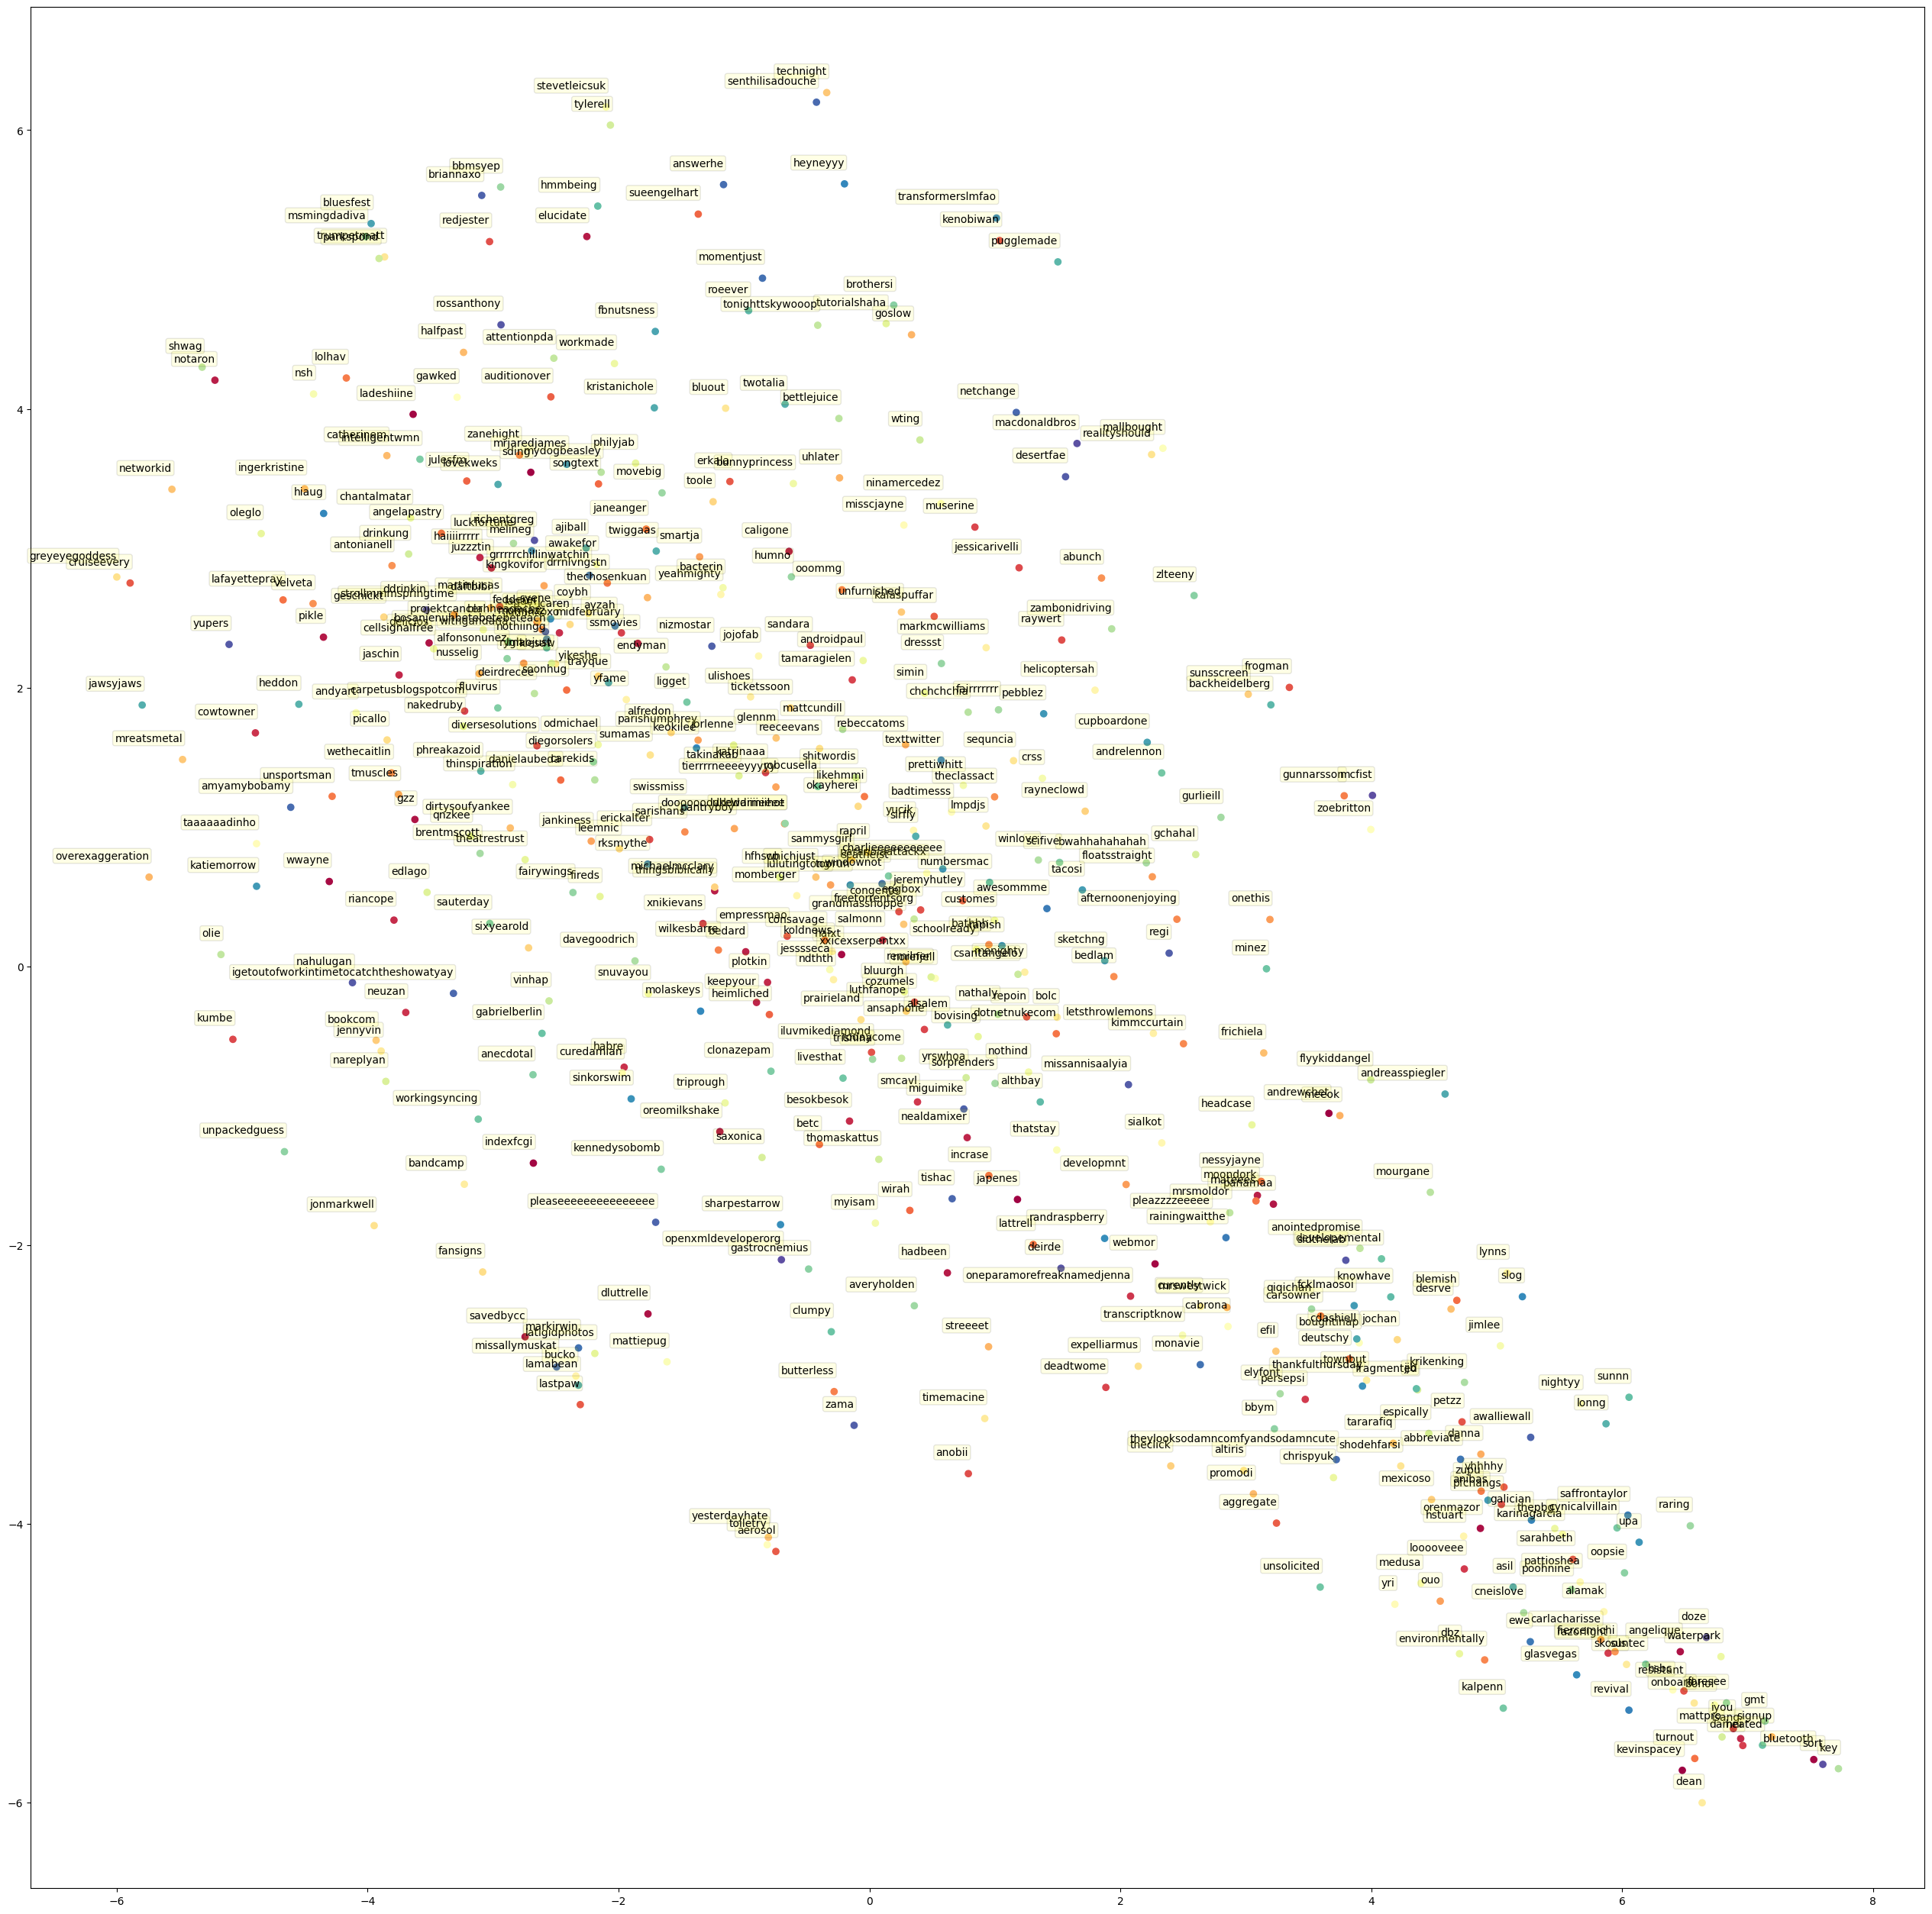

In [122]:
%%time
from sklearn.manifold import TSNE
import random
n_samples = 500
w2v_weights = word2vec_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
random_i = random.sample(range(vocab_size), n_samples)
random_w = [word2vec_model.wv.index_to_key[i] for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([word2vec_model.wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

> Sauvegarde des features word2vec

In [ ]:
%%time
np.save(f"{path}/embeddings_word2vec.npy", np.vstack(embeddings_word2vec))

CPU times: user 1.89 s, sys: 10.6 s, total: 12.5 s
Wall time: 33.3 s


> Sauvegarde du modéle word2vec pour les futurs modéles avancés

In [146]:
%%time
word2vec_model.save(f"{path}/word2vec_model.model")

CPU times: user 1.49 s, sys: 8.72 s, total: 10.2 s
Wall time: 19.9 s


#### FastText

In [125]:
%%time
fasttext_model = FastText(tokenized_texts, vector_size=300, window=5, min_count=1)

CPU times: user 16min 43s, sys: 7.1 s, total: 16min 50s
Wall time: 6min 56s


In [126]:
%%time
embeddings_fasttext = get_embeddings(fasttext_model, tokenized_texts, k=300)

print("Embedding matrix size", len(embeddings_fasttext), len(embeddings_fasttext[0]))
print("The sentence: \"%s\" got embedding values: " % tweets_df["lemmatize_text"][0])
print(embeddings_fasttext[0])

Embedding matrix size 1593071 300
The sentence: "switchfoot awww bummer shoulda get david carr third day" got embedding values: 
[-0.3234588  -0.992159   -0.6605737   0.17126372 -0.5284533   0.03977044
 -1.0764241   0.18080518  0.12973632  0.9727387  -0.52418786 -0.2894616
  0.426008    1.1541672   0.71181726  0.46830717  0.31504375  0.00187866
  1.4318911  -0.17936309 -0.22313516  0.01029084 -0.13340488 -0.5083007
  0.2251014   0.3983632  -0.5202229  -0.46418798 -1.1570451   0.41497037
 -0.5412414   0.01602711 -0.90311474  0.31077564 -0.04177075  0.22829969
 -0.15711921  0.15208718  0.00714882  1.1997936   0.8921333   0.9822905
  0.5732302   0.47717    -1.1073874   0.9587224  -0.04264218  0.40723765
  0.8710413  -0.2749045   0.64545155  0.7290232   0.11154858 -0.08567134
  1.1857294  -0.02083569  0.09493683 -1.5423924   0.1136689  -0.14312443
 -0.50016296 -0.04072439  0.87263316  0.19664197  0.8101291  -0.67508453
  0.09580967  0.0617713   0.6358631  -0.3264235  -0.6316601   0.1196504

In [127]:
fasttext_model.wv.most_similar(positive=["trump"])

[('trumphs', 0.9524090886116028),
 ('trumpetnb', 0.8989070057868958),
 ('trumpet', 0.8975552916526794),
 ('trubty', 0.887412965297699),
 ('trumpy', 0.8855424523353577),
 ('trumbull', 0.8834316730499268),
 ('truce', 0.8816749453544617),
 ('trum', 0.8812034130096436),
 ('truc', 0.8796937465667725),
 ('truzzle', 0.8791216015815735)]

In [131]:
fasttext_model.wv.vectors.shape

(695643, 300)

> Sauvegarde des features fastText

In [ ]:
%%time
np.save(f"{path}/embeddings_fasttext.npy", np.vstack(embeddings_fasttext))

CPU times: user 1.62 s, sys: 4.74 s, total: 6.36 s
Wall time: 19 s


In [147]:
%%time
fasttext_model.save(f"{path}/fasttext_model.model")

CPU times: user 574 ms, sys: 3.31 s, total: 3.89 s
Wall time: 13.6 s


#### Bidirectional Encoder Representations from Transformers (BERT)


In [ ]:
%%time
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_preprocess = hub.KerasLayer(
    tfhub_handle_preprocess,
    trainable=False, name="preprocess"
)
bert_encoder = hub.KerasLayer(
    tfhub_handle_encoder,
    trainable=True, name="encoder"
)

CPU times: user 9.72 s, sys: 3.45 s, total: 13.2 s
Wall time: 22 s




> Test bert preprocessing



In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


> Test bert enconding

In [ ]:
bert_results = bert_encoder(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.1788362  -0.23532821  0.9570173  -0.39067608 -0.20859718 -0.99966097
  0.18750408  0.5010721  -0.43959388 -0.20681769  0.47851366 -0.47998765]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.2316349   0.37881228  0.20612077 ... -0.16753703  0.31791148
  -0.0559496 ]
 [ 0.71144724  0.05240272  0.4039933  ... -0.23849712  0.06221136
  -0.11749871]
 [ 0.31278363 -0.20193692  0.31673133 ...  0.22400208  0.68846744
  -0.67951286]
 ...
 [ 0.19328623  0.3724367   0.57984746 ... -0.25043368 -0.15593146
   0.2765646 ]
 [ 0.26625976  0.23777674  0.54345405 ... -0.14922866 -0.2386093
   0.2457992 ]
 [ 0.11941037  0.5005053   0.36981526 ... -0.18295774 -0.08711515
   0.33573133]]


In [ ]:
def create_pooled_output_dataset(texts, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(texts)
    ds = ds.batch(batch_size)

    # prétraitement
    ds = ds.map(lambda x: bert_preprocess(x),
                num_parallel_calls=tf.data.AUTOTUNE)

    # encodage -> pooled_output
    ds = ds.map(lambda x: bert_encoder(x)['pooled_output'],
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def extract_all_embeddings(texts, batch_size=32):
    dataset = create_pooled_output_dataset(texts, batch_size=batch_size)
    embeddings = []
    for batch in tqdm(dataset, desc="Generating BERT embeddings"):
        embeddings.append(batch.numpy())
    return np.vstack(embeddings)

In [ ]:
%%time
embeddings_bert = extract_all_embeddings(tweets_df.lemmatize_text[:10000])

print("Shape des embeddings:", embeddings_bert.shape)  # (N, 768)

Generating BERT embeddings: 100%|██████████| 313/313 [12:14<00:00,  2.35s/it]

Shape des embeddings: (10000, 768)
CPU times: user 1h 30min 42s, sys: 3min 36s, total: 1h 34min 18s
Wall time: 12min 15s


In [ ]:
%%time
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{embeddings_bert.shape}')
print(f'Pooled Outputs Values:{embeddings_bert[0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Pooled Outputs Shape:(10000, 768)
Pooled Outputs Values:[-0.03516729 -0.04330144  0.934831   -0.26250058  0.02496504  0.9993337
 -0.12736808  0.85533583 -0.02469626 -0.15586057  0.3689517  -0.90029013]
CPU times: user 555 µs, sys: 978 µs, total: 1.53 ms
Wall time: 426 µs


In [ ]:
%%time
np.save(f"{path}/embeddings_bert.npy", embeddings_bert)

In [145]:
%%time
# Sauvegarder les targets et les contents
np.save(f"{path}/targets.npy", tweets_df.target.values)
tokenized_texts.to_csv(f"{path}/tokenized_tweets.csv", index=False, header=['tokenized_tweets'])

CPU times: user 6.19 s, sys: 211 ms, total: 6.4 s
Wall time: 7.17 s


In [ ]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=1647.0867309570312 seconds


# FIN